In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

import pickle

import sys
sys.path.append("..")

import neuroprob as mdl
import neuroprob.utils as utils



dev = utils.pytorch.get_device()


PyTorch version: 1.7.1+cu101
Using device: cuda:0


In [ ]:
#session_id = 'Mouse12-120806'
session_id = 'Mouse28-140313'
phase = 'wake'

datadir = '..'

sample_bin, use_samples, x_t, y_t, hd_t, \
    units, use_t_spike, track_samples, sep_t_spike, \
    refract_viol, neuron_groups, \
    wake, SWS, REM = pickle.load(open(datadir+'/data/datasets/th1_{}_{}.p'.format(session_id, phase), 'rb'))

#arena = np.array([0, 540., 0, 360.])

# resample
bin_size = 20
tbin, resamples, rc_t, (rx_t, ry_t, rhd_t,) = utils.neural.bin_data(bin_size, sample_bin, use_t_spike, use_samples, 
                                                        (x_t, y_t, np.unwrap(hd_t),), average_behav=True)
rhd_t = rhd_t % (2*np.pi)

r_t_spike = []
for u in range(units):
    r_t_spike.append(utils.neural.binned_to_indices(rc_t[u]))
    
print(tbin)

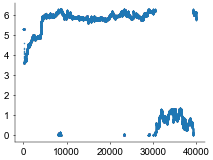

In [22]:
plt.scatter(np.arange(40000), rhd_t[:40000] % (2*np.pi), s=1, marker='.')

In [9]:
# binning of covariates and analysis
bins_hd = 60
bin_hd = np.linspace(0, 2*np.pi+1e-3, bins_hd+1)

hd_rate, hd_prob = utils.neural.IPP_model(tbin, 0.0, (rhd_t,), (bin_hd,), r_t_spike, divide=True)
hd_MI = utils.neural.spike_var_MI(hd_rate, hd_prob)

filter_win = 41
centre_win = filter_win//2
sigma = 6
sfilter = np.exp(-0.5*(np.arange(filter_win)-centre_win)**2/sigma**2)
sfilter = sfilter / sfilter.sum()
sm_tun = utils.neural.smooth_hist(hd_rate, sfilter, ['periodic'], dev=dev)
coherence, sparsity = utils.neural.geometric_tuning(hd_rate, sm_tun, hd_prob)

ISI, LV = utils.neural.compute_ISI_LV(tbin, r_t_spike)

In [65]:
criterion = {'refractory': 2.0, 'spatial_info': 0.5, 'sparsity': 0.2}

unit_used = []
for u in range(units):
    if ('spatial_info' in criterion and hd_MI[u] < criterion['spatial_info']) or \
       ('coherence' in criterion and coherence[u] < criterion['coherence']) or \
       ('refractory' in criterion and refract_viol[u] > criterion['refractory']) or \
       ('sparsity' in criterion and sparsity[u] < criterion['sparsity']):
        continue

    unit_used.append(u)
    
units_used = len(unit_used)
print(units_used)

33


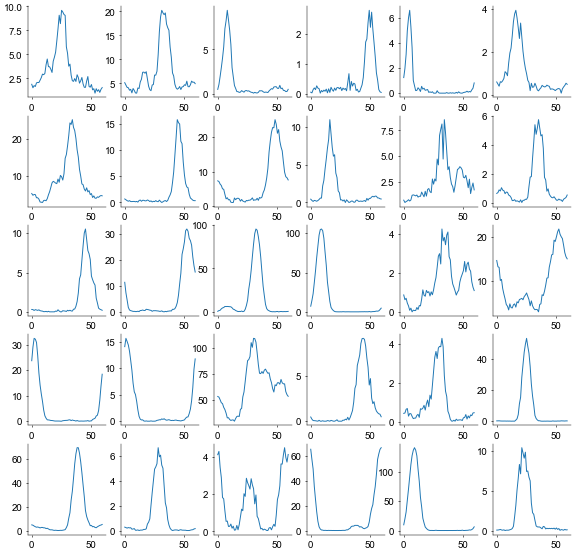

In [38]:
plt.figure(figsize=(10, 10))

for i in range(30):
    u = unit_used[i+5]
    
    plt.subplot(5, 6, i+1)
    plt.plot(hd_rate[u])

plt.show()

In [45]:
np.array(unit_used)

array([ 7,  9, 11, 12, 13, 20, 21, 22, 24, 26, 27, 28, 30, 31, 45, 52, 55,
       56, 57, 58, 60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 75, 76,
       77])

In [46]:
np.array(unit_used_)

array([ 7,  9, 11, 12, 20, 21, 22, 24, 26, 27, 28, 30, 31, 45, 52, 55, 56,
       57, 58, 60, 61, 62, 63, 64, 67, 68, 70, 71, 72, 73, 75, 76, 77])

In [14]:
# Mouse12 has ANT-CA1
edge = np.where(np.array(unit_used) > max(neuron_groups['ANT']))[0]
print(edge)
unit_used[20]

[20]


81

In [66]:
# Mouse28 have PoS-ANT
print(np.where(np.array(unit_used) > max(neuron_groups['PoS']))[0])
print(np.where(np.array(unit_used) > max(neuron_groups['ANT']))[0])
edge = np.array([15])
print(unit_used[15])

[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]
[]
55


In [67]:
# remove invalid region at start
inv_ind = np.where(rx_t == -1)[0]
rx_t = rx_t[inv_ind[-1]+1:]
ry_t = ry_t[inv_ind[-1]+1:]
rhd_t = rhd_t[inv_ind[-1]+1:]
rc_t = rc_t[:, inv_ind[-1]+1:]

In [28]:
left_x = rx_t.min()
right_x = rx_t.max()
bottom_y = ry_t.min()
top_y = ry_t.max()

arena = np.array([left_x, right_x, bottom_y, top_y])

spktrain = rc_t[unit_used]
np.savez_compressed('./checkpoint/{}_{}'.format(session_id, phase), spktrain=spktrain, 
                    arena=arena, x_t=rx_t, y_t=ry_t, hd_t=rhd_t, region_edge=edge) # edge is the start of new brain region

In [17]:
# Mouse12
left_over = np.delete(np.arange(units), unit_used)
print(np.where(left_over > max(neuron_groups['ANT'])))
print(np.where(left_over > max(neuron_groups['mPFC'])))

edge = np.array([34, 57])

(array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]),)
(array([57, 58, 59, 60, 61, 62, 63]),)


In [68]:
# Mouse28
left_over = np.delete(np.arange(units), unit_used)
print(np.where(left_over > max(neuron_groups['PoS']))[0])

edge = np.array([38])

[38 39 40 41 42 43 44 45 46 47 48]


In [30]:
# leftover units
# Mouse28 have PoS-ANT
# Mouse12 has ANT-CA1

spktrain = rc_t[left_over]
np.savez_compressed('../{}_{}_leftover'.format(session_id, phase), spktrain=spktrain, 
                    x_t=rx_t, y_t=ry_t, hd_t=rhd_t, region_edge=edge)

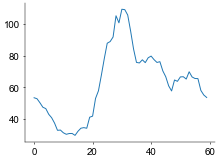

In [51]:
u = 66#left_over[8] # 8, 
plt.plot(hd_rate[u])

In [69]:
spktrain = rc_t[left_over]

In [70]:
spktrain.shape

(49, 2286282)